In [ ]:
# Importing the required dependencies
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import time
import warnings
warnings.filterwarnings("ignore")

from utils import load_txt_data, data_preprocessing, pairs_source_target, create_dataset
from utils import tokenize, load_dataset, convert, convert_str, BLEUscore_test
from model_attention import Encoder, Attention, Decoder, loss_function, train_step
from model_attention import evaluate, plot_attention, predict

In [45]:
# Downloading data from the network to the file system
load_txt_data()

In [46]:
print(os.listdir())

['.config', 'training_checkpoints', 'test.c.txt', 'train.c.txt', 'sample_data']


In [47]:
# loading data from the file system and their preprocessing
list_source_target_sents = data_preprocessing()
len(list_source_target_sents)

7544

In [48]:
# Create pairs: source / target 
list_source_sent, list_target_sent = pairs_source_target(list_source_target_sents) 
list_source_sent[5], list_target_sent[5]

('The bus driver yelled at a kid after she broke a window.',
 'she The bus driver a kid a kid')

In [49]:
# Let's create pairs in the format: [source, target]
source_list, target_list = create_dataset(list_source_sent, list_target_sent)

In [50]:
source_list[0], target_list[0]

('<start> the bee landed on the flower because it had pollen . <end>',
 '<start> it the bee the flower the flower <end>')

In [51]:
# Let's create the final data and see the sample data
input_tensor, target_tensor, inp_seq, targ_seq = load_dataset(list_source_sent, list_target_sent)

# Let's see the maximum length of tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [52]:
input_tensor[0], target_tensor[0]

(array([   3,    1, 1471, 1472,   28,    1, 1473,    6,   15,   30, 1474,
           2,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0], dtype=int32),
 array([  2,   6,   1, 425,   1, 426,   1, 426,   3,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0], dtype=int32))

In [53]:
max_length_targ, max_length_inp

(20, 39)

In [54]:
# Map indices to words
print ("Input sequence; index to word mapping")
convert(inp_seq, input_tensor[0])
print ()
print ("Target sequence; index to word mapping")
convert(targ_seq, target_tensor[0])

Input sequence; index to word mapping
3 ----> <start>
1 ----> the
1471 ----> bee
1472 ----> landed
28 ----> on
1 ----> the
1473 ----> flower
6 ----> because
15 ----> it
30 ----> had
1474 ----> pollen
2 ----> .
4 ----> <end>

Target sequence; index to word mapping
2 ----> <start>
6 ----> it
1 ----> the
425 ----> bee
1 ----> the
426 ----> flower
1 ----> the
426 ----> flower
3 ----> <end>


In [55]:
# Let's create training and test datasets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.1)

# Let's see the dimensions
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

1697 1697 189 189


In [56]:
input_tensor_val[0]

array([  3, 534, 111, 293,   6,   8, 134, 839,  60, 294,   2,   4,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [57]:
target_tensor_val[0]

array([  2,   5, 132,  69, 132,   3,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [58]:
# Convert a tensor to a sentence
conv_str = convert_str(inp_seq, input_tensor_val[0])
conv_str

' robert fired chris because he no longer needed workers .  '

In [60]:
# Create tf.data dataset and hyperparameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 16
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
attention_units = 10
vocab_inp_size = len(inp_seq.word_index)+1
vocab_tar_size = len(targ_seq.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [61]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([16, 39]), TensorShape([16, 20]))

In [62]:
# Initializing the encoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Encoder Output and Hidden State Sizes
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (16, 39, 1024)
Encoder Hidden state shape: (batch size, units) (16, 1024)


In [63]:
# Initializing Attention
attention_layer = Attention(attention_units)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (16, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (16, 39, 1)


In [64]:
# decoder initialization
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (16, 1448)


In [65]:
# Defining an optimizer and a loss function
learning_rate=0.001  # 0.00025
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [66]:
# Save model breakpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [67]:
# Model training
EPOCHS = 20 

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
    # Сохраним модель каждые 10 эпох
    if (epoch + 1) % 10 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.3426
Epoch 1 Batch 50 Loss 1.6743
Epoch 1 Batch 100 Loss 2.1039
Epoch 1 Loss 1.9244
Time taken for 1 epoch 50.74118995666504 sec

Epoch 2 Batch 0 Loss 1.5458
Epoch 2 Batch 50 Loss 1.8589
Epoch 2 Batch 100 Loss 1.3676
Epoch 2 Loss 1.6001
Time taken for 1 epoch 26.012818098068237 sec

Epoch 3 Batch 0 Loss 1.3592
Epoch 3 Batch 50 Loss 1.5751
Epoch 3 Batch 100 Loss 1.3717
Epoch 3 Loss 1.4258
Time taken for 1 epoch 25.982136249542236 sec

Epoch 4 Batch 0 Loss 1.2795
Epoch 4 Batch 50 Loss 1.2334
Epoch 4 Batch 100 Loss 1.1049
Epoch 4 Loss 1.2539
Time taken for 1 epoch 25.978865146636963 sec

Epoch 5 Batch 0 Loss 1.2782
Epoch 5 Batch 50 Loss 1.0383
Epoch 5 Batch 100 Loss 0.9819
Epoch 5 Loss 1.0994
Time taken for 1 epoch 25.92420983314514 sec

Epoch 6 Batch 0 Loss 0.8820
Epoch 6 Batch 50 Loss 0.9929
Epoch 6 Batch 100 Loss 0.6793
Epoch 6 Loss 0.9292
Time taken for 1 epoch 25.98442244529724 sec

Epoch 7 Batch 0 Loss 0.7065
Epoch 7 Batch 50 Loss 0.7644
Epoch 7 Batch 100 Loss

In [ ]:
# Restoring the last checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> lions eat zebras because they are meaty . <end>
Predicted: they lions zebras zebras <end> 


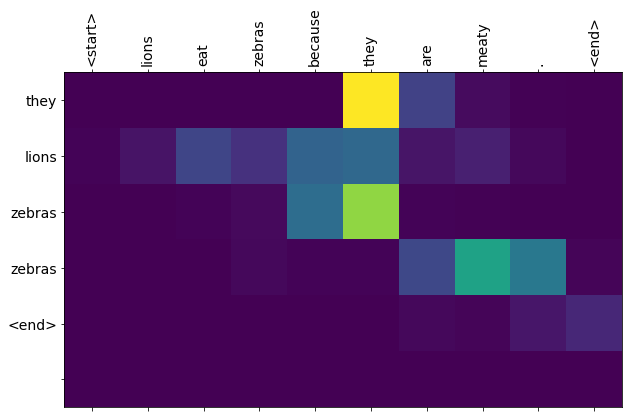

In [27]:
# Correct sequence of 2nd, 3rd, 4th lines:
# they
# Lions,zebras
# zebras
predicted = predict(u"Lions eat zebras because they are meaty.")

Input: <start> john hired bill because he needed someone . <end>
Predicted: he john bill john <end> 


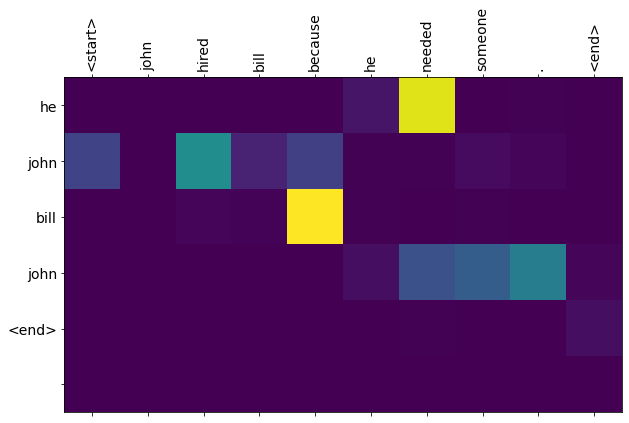

In [28]:
predicted = predict(u"John hired Bill because he needed someone.")

True target:  his randy nick randy  
Input: <start> randy went to nick s store , and bought his groceries . <end>
Predicted: his randy nick nick <end> 


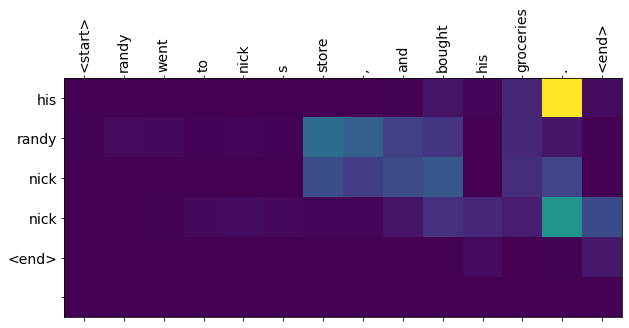

In [30]:
print(f'True target: {convert_str(targ_seq, target_tensor_val[55])}')
predicted = predict(convert_str(inp_seq, input_tensor_val[55]))

In [68]:
# The quality of the model's performance on test data that the model has never seen
BLEU = BLEUscore_test(inp_seq, targ_seq, input_tensor_val, target_tensor_val)
print(f'BLEU Score = {BLEU}')

BLEU Score = 0.6514762783227631
